***
### Guía 4 - Ejercicio 1 - Camila
Calcule las frecuencias naturales de oscilación transversal de una barra de acero (densidad 7850 kg/m3 y módulo de elasticidad E = 210 GPa), de 1 m de longitud, 10 cm2 de área, momento de inercia de 10 cm4. Realice el cálculo para un número variable de elementos y estudie la convergencia de sus resultados. Haga el cálculo para matrices de masa concentrada y consistente. Grafique los desplazamientos en función de la posición para los primeros modos normales.
***

#### Comienzo del programa
Se importan las librerías de las funciones a utilizar durante el programa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
np.set_printoptions(precision=4, linewidth=150)

#### Definición de constantes y datos del problema
Debajo se definen los valores y datos a utilizar para el desarrollo del problema. Donde se tiene:
* **_density_**: Es la densidad del material. Las unidades que poseen son kg/m^3
* **_area_**: Es el área que posee la barra de acero. Las unidades que posee son m^2
* **_young_**: Es el modulo de elasticidad. Las unidades que deben utilizarse es Pascales
* **_totalLen_**: Es el largo total de la barra. Las unidades a utilizarse son metros
* **_inertia_**: Es el momento de inercia de la barra. Las unidades en las que se tiene que poner es en m^4
* **_elementsNumber_**: Es el número de elementos en que se quiere dividir el problema.
* **_nodesNumber_**: Se calcula el número de elementos sumando un 1, dado que el sistema es transversal.
* **_L_**: Corresponde al largo de cada uno de los elementos, los cuales por simplicidad tendrán igual tamaño

In [2]:
density = 7850
area = 10E-4
young = 210E9
totalLen = 1
inertia = 10E-8
elementsNumber = 3
nodesNumber = elementsNumber + 1
L = totalLen/elementsNumber

#### Declaración de variables y matrices
Se realiza previo a la utilización la declaración de todas las matrices, de manera de únicamente ir llenando los espacios y evitar cualquier problema. 

Dado que es una barra y voy a tomar los nodos según la cantidad de elementos que elija, mediante un linspace se hace una división de la barra de largo total "totalLen", en iguales elementos por simplicidad para obtener los nodos y su posición. Además, al agregarle el reshape(-1,1), cambio su forma de fila a columna.

Por otro lado, a la misma matriz de nodos, se le agrega otro vector columna de igual tamaño, de manera de que quede con el tamaño correcto, debido a ?????????

In [3]:
nodeMatrix = np.linspace(0, totalLen, nodesNumber).reshape(-1, 1)
nodeMatrix = np.hstack([nodeMatrix, np.zeros_like(nodeMatrix)])
globalStiffMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))

La **matriz de conectividad**, dado que todos los elementos estan en una línea, es decir, elemento 0 se conecta con el 1 y el 1 a su vez con el 2, se puede escribir automáticamente de la siguiente manera:

In [4]:
conectivityMatrix = np.zeros((elementsNumber, 2))

for i in range(elementsNumber):
    conectivityMatrix[i, 0] = i
    conectivityMatrix[i, 1] = i + 1

**Condiciones de vínculo**

Para decir que en el caso este, el punto se que encuentra amarrado es el primero y por lo tanto, las dos primeras posiciones son las que van a estar definidas. Mientras que r corresponde al resto de los nodos que se tienen, sacando los dos primeros. Se considera que en total tengo 8 grados de libertad, 4 correspondientes a los desplazamientos y 4 a los ángulos.

In [5]:
s = [0, 1]
r = (np.linspace(2, 2*nodesNumber - 1, 2*nodesNumber - 2)).astype(int)
# print(r)

***
#### Análisis de los primeros modos normales
Se realiza el calculo de las matrices de rigidez, concentrada y consisntente. La declaración de las variables y las matrices se dejan fuera del for para evitar realizar varias veces el mismo cálculo. 

In [6]:
concentratedGlobalMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))
consistentGlobalMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))

stiffCoef = young * inertia / L**3
preCoefConc = (density * area * L) / 24
preCoefConsist = (density * area * L) / 420

In [7]:
for i in range(len(conectivityMatrix)):
    node1, node2 = conectivityMatrix[i]
    node1 = int(node1)
    node2 = int(node2)
    cupleA = [2*node1, 2*node1 + 1] #MDF_COMMENT cuple or couple?
    cupleB = [2*node2, 2*node2 + 1]

    index1 = np.array([0, 1])
    index2 = np.array([2, 3])

    # Cálculo de la matriz de rigidez
    stiffMatrix = np.array([
                        [12,  6*L,    -12,  6*L],
                        [6*L, 4*L**2, -6*L, 2*L**2],
                        [-12, -6*L,    12, -6*L],
                        [6*L, 2*L**2, -6*L, 4*L**2]
                       ])

    k = stiffCoef * stiffMatrix

    globalStiffMatrix[np.ix_(cupleA, cupleA)] += k[np.ix_(index1, index1)]
    globalStiffMatrix[np.ix_(cupleB, cupleA)] += k[np.ix_(index2, index1)]
    globalStiffMatrix[np.ix_(cupleB, cupleB)] += k[np.ix_(index2, index2)]
    globalStiffMatrix[np.ix_(cupleA, cupleB)] += k[np.ix_(index1, index2)]

    # Cálculo de la matriz concentrada
    concMatrix = np.array([
                           [12, 0, 0, 0],
                           [0, L**2, 0, 0],
                           [0, 0, 12, 0],
                           [0, 0, 0, L**2]
                          ])

    concentratedMatrix = preCoefConc * concMatrix

    concentratedGlobalMatrix[np.ix_(cupleA, cupleA)] += concentratedMatrix[np.ix_(index1, index1)]
    concentratedGlobalMatrix[np.ix_(cupleB, cupleA)] += concentratedMatrix[np.ix_(index2, index1)]
    concentratedGlobalMatrix[np.ix_(cupleB, cupleB)] += concentratedMatrix[np.ix_(index2, index2)]
    concentratedGlobalMatrix[np.ix_(cupleA, cupleB)] += concentratedMatrix[np.ix_(index1, index2)]

    # Cálculo de la matriz consistente
    consMatrix = np.array([
                            [156, 22*L, 54, -13*L],
                            [22*L, 4*L**2, 13*L, -3*L**2],
                            [54, 13*L, 156, -22*L],
                            [-13*L, -3*L**2, -22*L, 4*L**2]
                          ])

    consistentMatrix = preCoefConsist * consMatrix

    consistentGlobalMatrix[np.ix_(cupleA, cupleA)] += consistentMatrix[np.ix_(index1, index1)]
    consistentGlobalMatrix[np.ix_(cupleB, cupleA)] += consistentMatrix[np.ix_(index2, index1)]
    consistentGlobalMatrix[np.ix_(cupleB, cupleB)] += consistentMatrix[np.ix_(index2, index2)]
    consistentGlobalMatrix[np.ix_(cupleA, cupleB)] += consistentMatrix[np.ix_(index1, index2)]

Importamos una funcion que resuelve el sistema de autofunciones que se tienen y luego se calculan las frecuencias. Se hace con los vectores

In [8]:
concentratedW, concentratedVr = eigh(globalStiffMatrix[np.ix_(r, r)], concentratedGlobalMatrix[np.ix_(r, r)])
consistentW, consistentVr = eigh(globalStiffMatrix[np.ix_(r, r)], consistentGlobalMatrix[np.ix_(r, r)])

Dado que se restringieron con el vector "s" los dos primeros grados de libertad, se deben agregar dos filas de ceros por encima, para completar todos los datos. Esto se realiza mediante un np.vstack, en el cual simplmente agrego una matriz de ceros de 2* elementos

In [9]:
concentratedV = np.vstack([np.zeros((2, 2*elementsNumber)), concentratedVr])
consistentV = np.vstack([np.zeros((2, 2*elementsNumber)), consistentVr])

Los autovectores me dan los desplzamientos, pero proporcionalmente, tengo que buscar que la ultima de las y's sea 1 -> tengo que normalizar, porque cualquier vector multiplicado por cualquier constante, sigue siendo autovector

Dado que las omegas que fueron calculadas son omega cuadrado, se deben realizar los calculos para pasarlo a frecuencia

In [10]:
concentratedFrec = np.sqrt(concentratedW)/(2*np.pi)
consistentFrec = np.sqrt(consistentW)/(2*np.pi)

Los autovectores son modos transversales, por los datos y matrices utilizados. Además, se debe realizar el normalizado por el último valor de y, que corresponde al anteúltimo elemento del vector.

In [11]:
normConcentratedV = concentratedV / concentratedV[2*nodesNumber-2, :]
normConsistentV = consistentV / consistentV[2*nodesNumber-2, :]

***
### Gráficos

In [12]:
# cantidad de modos normales que quiero graficar
modesNumber = 3

#### Gráficos forma directa

Dado la forma en que están los datos en la matriz de autovectores, que serían como columna cada autovector, se toman los valores impares (pares para python) de cada columna, que son los que corresponden a los desplazamientos en y. 

Text(0.5, 1.0, 'Diferentes modos de vibración - Gráfico directo')

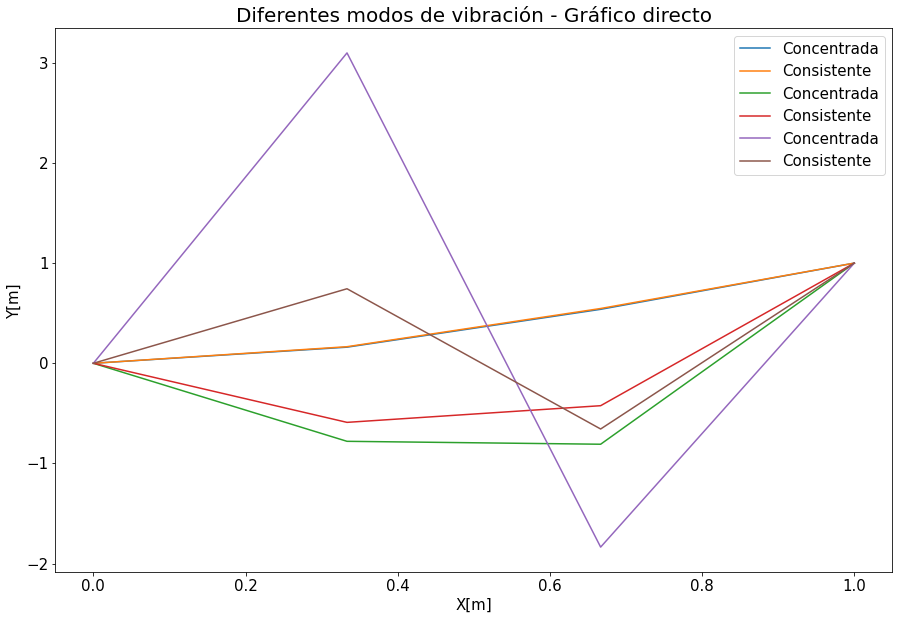

In [13]:
concentratedDisplacementMatrix = normConcentratedV[::2]  # Con esto me quedo unicamente con los impares.
consistentDisplacementMatrix = normConsistentV[::2]

# las posiciones van a ser los nodos en x.
xVector = nodeMatrix[:, 0]

plt.rc('figure', figsize=(15, 10))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

for i in range(modesNumber):
    concentratedDisplacements = concentratedDisplacementMatrix[:, i]
    consistentDisplacements = consistentDisplacementMatrix[:, i]
    plt.plot(xVector, concentratedDisplacements, label='Concentrada')
    plt.plot(xVector, consistentDisplacements, label='Consistente')


plt.legend()
plt.xlabel('X[m]', fontsize=15)
plt.ylabel('Y[m]', fontsize=15)
plt.title('Diferentes modos de vibración - Gráfico directo', fontsize=20)

#### Gráficos con interpolaciones

Considerando que los autovectores me dan los desplazamientos en las posiciones pares y en los impares las tangentes de los ángulos, debería hacer las funciones de interpolación para poder graficar. Según lo visto para vigas, se puede hacer una interpolación simple considerando una funcion de interpolación v.

Text(0.5, 1.0, 'Diferentes modos de vibración - Matriz concentrada - Interpolación')

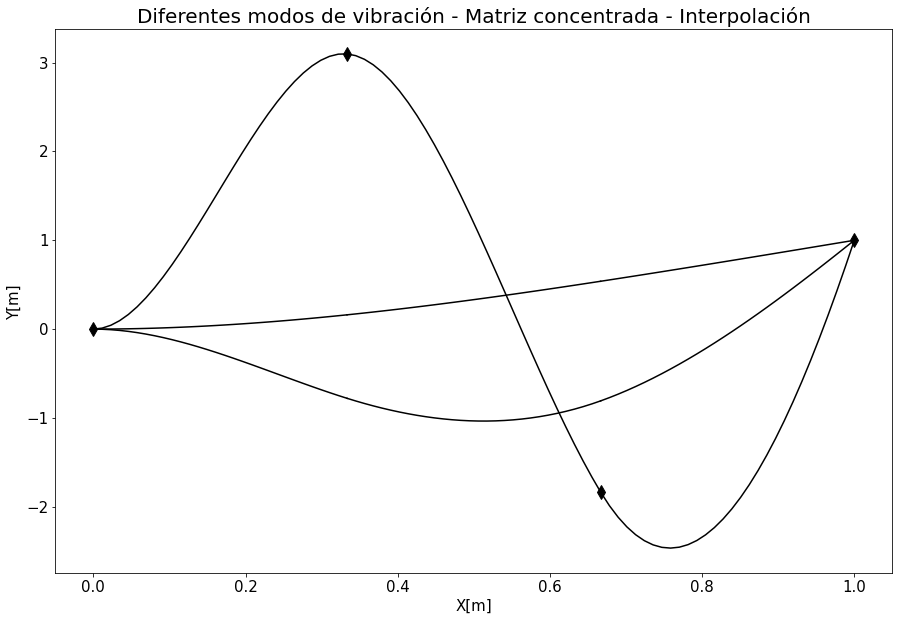

In [17]:
v = lambda a1, a2, a3, a4, x: a1*x**3 + a2*x**2 + a3*x + a4

plt.rc('figure', figsize=(15, 10))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

for j in range(modesNumber):
    # El for en j, hace los gráficos de los modos que quiero. Y a su vez, el for en i, me grafica cada modo en su totalidad
    for i in range(elementsNumber):
        A1 = 2/L**3 * (normConcentratedV[2*i][j] - normConcentratedV[2*(i + 1)][j]) + 1/L**2 * (normConcentratedV[2*i + 1][j] + normConcentratedV[2*(i + 1) + 1][j])
        A2 = -3/L**2*(normConcentratedV[2*i][j] - normConcentratedV[2*(i + 1)][j]) - 1/L * (2*normConcentratedV[2*i + 1][j] + normConcentratedV[2*(i + 1) + 1][j])
        A3 = normConcentratedV[2*i + 1][j]
        A4 = normConcentratedV[2*i][j]

        plt.plot(np.linspace((0 + 2*i)/(2*elementsNumber), (2 + 2*i)/(2*elementsNumber), 30), v(A1, A2, A3, A4, np.linspace(0, L, 30)), 'k')

#MDF_COMMENT y le podemos agregar los puntos originales, no ?
plt.plot(xVector, concentratedDisplacements, 'dk', ms=10, label='Concentrada')
plt.xlabel('X[m]', fontsize=15)
plt.ylabel('Y[m]', fontsize=15)
plt.title('Diferentes modos de vibración - Matriz concentrada - Interpolación', fontsize=20)

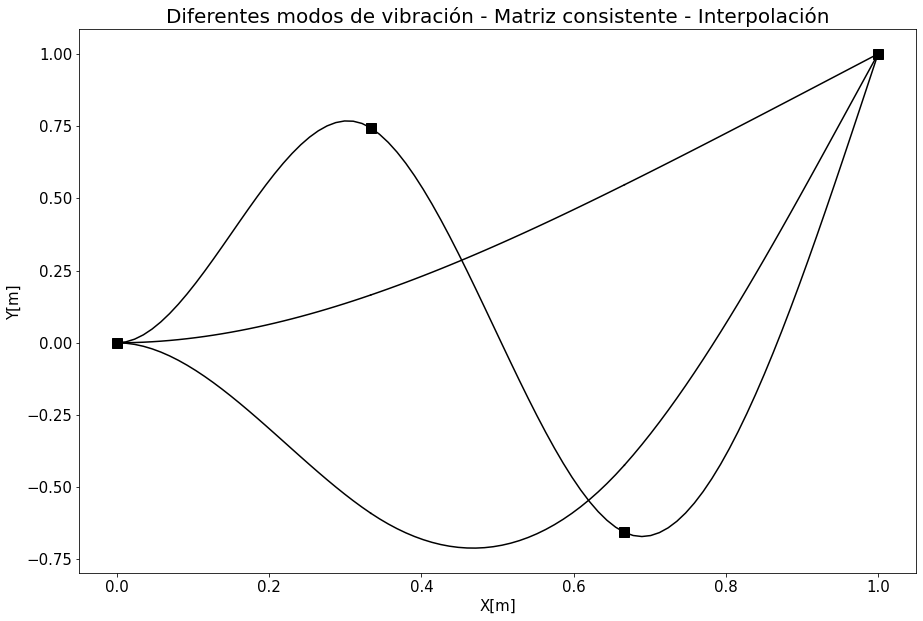

In [16]:
plt.rc('figure', figsize=(15, 10))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

for j in range(modesNumber):
    # El for en j, hace los gráficos de los modos que quiero. Y a su vez, el for en i, me grafica cada modo en su totalidad
    for i in range(elementsNumber):

        B1 = 2/L**3 * (normConsistentV[2*i][j] - normConsistentV[2*(i + 1)][j]) + 1/L**2 * (normConsistentV[2*i + 1][j] + normConsistentV[2*(i + 1) + 1][j])
        B2 = - 3/L**2*(normConsistentV[2*i][j] - normConsistentV[2*(i + 1)][j]) - 1/L * (2*normConsistentV[2*i + 1][j] + normConsistentV[2*(i + 1) + 1][j])
        B3 = normConsistentV[2*i + 1][j]
        B4 = normConsistentV[2*i][j]

        plt.plot(np.linspace((0 + 2*i)/(2*elementsNumber), (2 + 2*i)/(2*elementsNumber), 30), v(B1, B2, B3, B4, np.linspace(0, L, 30)), 'k')

#MDF_COMMENT y le podemos agregar los puntos originales, no ?
plt.plot(xVector, consistentDisplacements, 'sk', ms=10, label='Consistente')
plt.xlabel('X[m]', fontsize=15)
plt.ylabel('Y[m]', fontsize=15)
plt.title('Diferentes modos de vibración - Matriz consistente - Interpolación', fontsize=20)
plt.show()

<div style="background-color:#330033">yo le agregaría que la linea para cada modo sea de distinto color, y le pondría la leyenda para que se entienda. a demas estas graficando para distintos numeros de nodos, eso tambien tendŕia que estar.</div>

<div style="background-color:#330033">Fijate que en las dos celdas de arriba haces la misma operación sobre dos vectores que tienen el mismo formato. en general eso se hace con una función que escribis una vez y la aplicas una  vez a cada argumento. igual esta muy bien, te escribo esto porque no te puedo criticar otra cosa</div>

***
### Análisis de convergencia

Se hace un gráfico de convergencia, esto se realiza con un for para recorrer distintas cantidades de elementos. Dado que para un solo elemento no se tienen 3 modos normales y el análisis que se va hacer es con 3 modos, se saca de consideración y se pone como minimo 2 elementos.  En cada modo, se toma la frecuencia mas chica, se toman los 3 primeros modos y por cada uno se analiza con mas elementos. Se ve que conforme aumente el numero de modo es mas lento en cuanto a la convergencia, y necesita mayor cantidad de elementos para converger. 

#### Cálculo para diferente cantidad de elementos

El programa es inicialmente igual al de arriba, con el pequeño cambio de que ahora se calcula según la cantidad de elementos se quiera ver la convergencia "convergenceRangeMax" por medio de un for.

In [16]:
convergenceRangeMax = 20
concentratedFrecVector = []
consistentFrecVector = []
normalModeConcentrated1 = np.zeros([convergenceRangeMax-2, 1])
normalModeConcentrated2 = np.zeros([convergenceRangeMax-2, 1])
normalModeConcentrated3 = np.zeros([convergenceRangeMax-2, 1])
normalModeConsistent1 = np.zeros([convergenceRangeMax-2, 1])
normalModeConsistent2 = np.zeros([convergenceRangeMax-2, 1])
normalModeConsistent3 = np.zeros([convergenceRangeMax-2, 1])

for j in range(2, convergenceRangeMax):
    # Declaración de variables y matrices
    elementsNumber = j
    nodesNumber = elementsNumber + 1
    L = totalLen/elementsNumber

    stiffCoef = young * inertia / L**3
    preCoefConc = (density * area * L) / 24
    preCoefConsist = (density * area * L) / 420

    nodeMatrix = np.linspace(0, totalLen, nodesNumber).reshape(-1, 1)
    nodeMatrix = np.hstack([nodeMatrix, np.zeros_like(nodeMatrix)])

    globalStiffMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))
    conectivityMatrix = np.zeros((elementsNumber, 2))

    concentratedGlobalMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))
    consistentGlobalMatrix = np.zeros((2*nodesNumber, 2*nodesNumber))

    # Armado de la matriz de conectividad
    for i in range(elementsNumber):
        conectivityMatrix[i, 0] = i
        conectivityMatrix[i, 1] = i + 1

    # Condiciones de contorno
    s = [0, 1]
    r = (np.linspace(2, 2*nodesNumber - 1, 2*nodesNumber - 2)).astype(int)

    # Cálculos de las matrices
    for h in range(len(conectivityMatrix)):
        node1, node2 = conectivityMatrix[h]
        node1 = int(node1)
        node2 = int(node2)

        cupleA = [2*node1, 2*node1 + 1]
        cupleB = [2*node2, 2*node2 + 1]

        index1 = np.array([0, 1])
        index2 = np.array([2, 3])

        # Cálculo de la matriz de rigidez
        stiffMatrix = np.array([
                        [12,  6*L,    -12,  6*L],
                        [6*L, 4*L**2, -6*L, 2*L**2],
                        [-12, -6*L,    12, -6*L],
                        [6*L, 2*L**2, -6*L, 4*L**2]
                       ])

        k = stiffCoef * stiffMatrix

        globalStiffMatrix[np.ix_(cupleA, cupleA)] += k[np.ix_(index1, index1)]
        globalStiffMatrix[np.ix_(cupleB, cupleA)] += k[np.ix_(index2, index1)]
        globalStiffMatrix[np.ix_(cupleB, cupleB)] += k[np.ix_(index2, index2)]
        globalStiffMatrix[np.ix_(cupleA, cupleB)] += k[np.ix_(index1, index2)]

        # Cálculo de la matriz concentrada
        concMatrix = np.array([
                           [12, 0, 0, 0],
                           [0, L**2, 0, 0],
                           [0, 0, 12, 0],
                           [0, 0, 0, L**2]
                          ])

        concentratedMatrix = preCoefConc * concMatrix

        concentratedGlobalMatrix[np.ix_(cupleA, cupleA)] += concentratedMatrix[np.ix_(index1, index1)]
        concentratedGlobalMatrix[np.ix_(cupleB, cupleA)] += concentratedMatrix[np.ix_(index2, index1)]
        concentratedGlobalMatrix[np.ix_(cupleB, cupleB)] += concentratedMatrix[np.ix_(index2, index2)]
        concentratedGlobalMatrix[np.ix_(cupleA, cupleB)] += concentratedMatrix[np.ix_(index1, index2)]

        # Cálculo de la matriz consistente
        consMatrix = np.array([
                            [156, 22*L, 54, -13*L],
                            [22*L, 4*L**2, 13*L, -3*L**2],
                            [54, 13*L, 156, -22*L],
                            [-13*L, -3*L**2, -22*L, 4*L**2]
                          ])

        consistentMatrix = preCoefConsist * consMatrix

        consistentGlobalMatrix[np.ix_(cupleA, cupleA)] += consistentMatrix[np.ix_(index1, index1)]
        consistentGlobalMatrix[np.ix_(cupleB, cupleA)] += consistentMatrix[np.ix_(index2, index1)]
        consistentGlobalMatrix[np.ix_(cupleB, cupleB)] += consistentMatrix[np.ix_(index2, index2)]
        consistentGlobalMatrix[np.ix_(cupleA, cupleB)] += consistentMatrix[np.ix_(index1, index2)]

    concentratedW, concentratedVr = eigh(globalStiffMatrix[np.ix_(r, r)], concentratedGlobalMatrix[np.ix_(r, r)])
    consistentW, consistentVr = eigh(globalStiffMatrix[np.ix_(r, r)], consistentGlobalMatrix[np.ix_(r, r)])

    concentratedV = np.vstack([np.zeros((2, 2*elementsNumber)), concentratedVr])
    consistentV = np.vstack([np.zeros((2, 2*elementsNumber)), consistentVr])

    concentratedFrec = np.sqrt(concentratedW) / (2*np.pi)
    consistentFrec = np.sqrt(consistentW) / (2*np.pi)

    concentratedFrecVector.append(concentratedFrec)
    # print(concentratedFrec)
    # print(consistentFrec)
    consistentFrecVector.append(consistentFrec)

Se realiza un for para tomar las primeras frecuencias de los primeros tres modos, para las diferentes cantidades de elementos y por cada método.

In [17]:
for p in range(convergenceRangeMax - 2):
    normalModeConcentrated1[p] = concentratedFrecVector[p][0]
    normalModeConcentrated2[p] = concentratedFrecVector[p][1]
    normalModeConcentrated3[p] = concentratedFrecVector[p][2]

    normalModeConsistent1[p] = consistentFrecVector[p][0]
    normalModeConsistent2[p] = consistentFrecVector[p][1]
    normalModeConsistent3[p] = consistentFrecVector[p][2]

# print(normalModeConcentrated1)
# print(normalModeConcentrated2)

Se grafica la convergencia de los 3 primeros modos de vibración para ambos métodos.

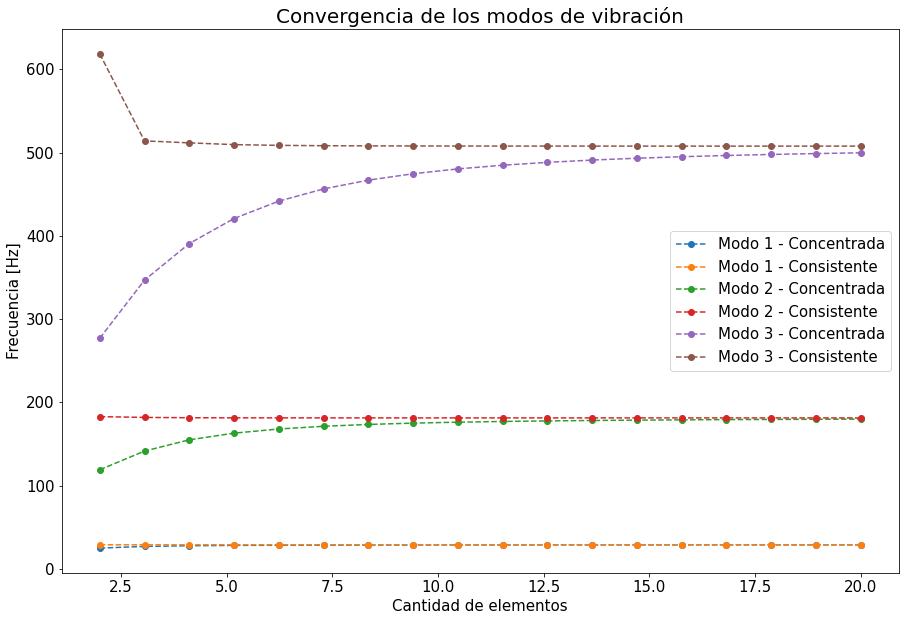

In [18]:
xPositions = np.linspace(2, convergenceRangeMax, convergenceRangeMax - 2)
plt.rc('figure', figsize=(15, 10))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

plt.plot(xPositions, normalModeConcentrated1, 'o', linestyle='dashed', label='Modo 1 - Concentrada')
plt.plot(xPositions, normalModeConsistent1, 'o', linestyle='dashed', label='Modo 1 - Consistente')

plt.plot(xPositions, normalModeConcentrated2, 'o', linestyle='dashed', label='Modo 2 - Concentrada')
plt.plot(xPositions, normalModeConsistent2, 'o', linestyle='dashed', label='Modo 2 - Consistente')

plt.plot(xPositions, normalModeConcentrated3, 'o', linestyle='dashed', label='Modo 3 - Concentrada')
plt.plot(xPositions, normalModeConsistent3, 'o', linestyle='dashed', label='Modo 3 - Consistente')

plt.xlabel('Cantidad de elementos', fontsize=15)
plt.ylabel('Frecuencia [Hz]', fontsize=15)
plt.legend()
plt.title('Convergencia de los modos de vibración', fontsize=20)
plt.show()

<div style="background-color:#330033">Impecable</div>